In [240]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialization

In [242]:
import numpy as np
import pandas as pd
import random

from graphviz import Digraph
import pydotplus

from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
import networkx as nx
    
from Utils_GRN import *

import matplotlib.pyplot as plt
%matplotlib inline
initialization()

num_cores=multiprocessing.cpu_count()
print(num_cores)
sigma=1     ###   variance of noise

32


In [243]:
obsN

5

# Generating the synthetic data

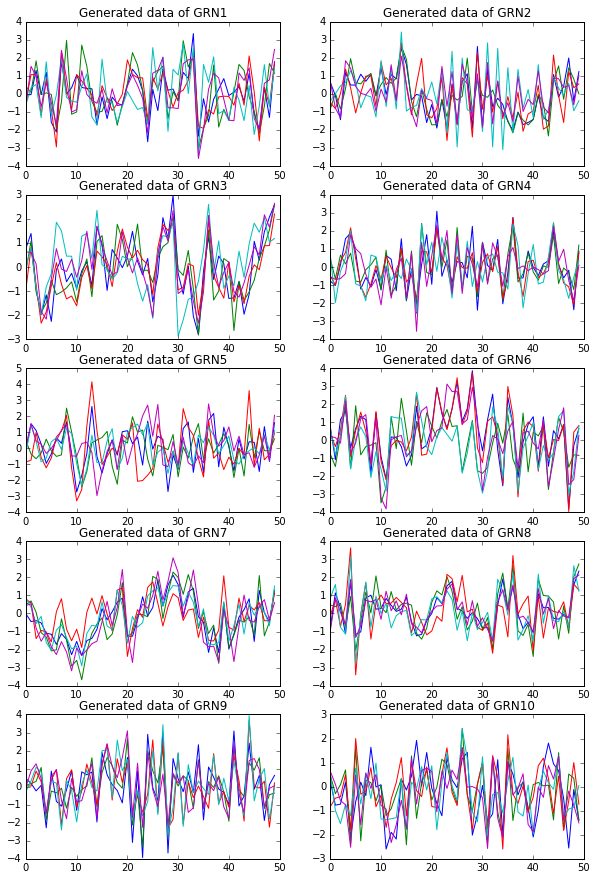

In [244]:
T=50  ## length of time series
Fig1 = plt.figure(1,figsize =(10,15))

for syn in range(n_syn):
    matrix_o,weight_o=orig_matrix()
    np.save('matrix'+str(syn+1),matrix_o)
      
    delay=max_neurons-1
    Data_orig=np.random.uniform(-1,1,[T+delay,obsN])
    Data_orig[delay+1:,:]=np.zeros([T-1,obsN])

    Data=Data_orig.copy()
    for t in range(delay,T+delay-1):
        for lag in range(0,delay+1):
            #Data[t+1,:]=Data[t+1,:]+np.dot(weight_o[lag],Data[t-lag,:]) ##  Linear
            Data[t+1,:]=Data[t+1,:]+np.tanh(np.dot(weight_o[lag],Data[t-lag,:])) ## Nonlinear
        Data[t+1,:]=Data[t+1,:]+np.random.normal(0, sigma)
        
        
    Data2=Data[delay:,:]     
    np.savetxt('Data_exp'+str(syn+1)+'_si_'+str(sigma)+'.csv',Data2, delimiter=",")
    Fig1.add_subplot(n_syn/2,2,syn+1) 
    plt.plot(Data2)
    plt.title('Generated data of GRN'+str(syn+1))
    
plt.savefig('Linear_'+str(obsN)+'genes_si'+str(sigma)+'.png')    
 
    

# Multiple runs of proposed method

In [245]:
if __name__ == '__main__':
    
    columns=['TP','FP','FN','Precision','Recall','F_score']
    A=[]
    for i in range(n_syn): ## 3 is len(['Link','Delay','Effect'])
        A.extend([i]*3)
        
    B=['Link','Delay','Effect']*n_syn
    index=[A,B]
    Accuracy=pd.DataFrame(np.random.randint(10, size=(n_syn*3,6)),index=index,columns=columns)    
          
    ###-----------------------------
    
    #matrix_P=[]
    for syn in tqdm(range(n_syn)): # multiple runs of the algorithm
        matrix_o=np.load('matrix'+str(syn+1)+'.npy')
        Data= pd.read_csv('Data_exp'+str(syn+1)+'_si_'+str(sigma)+'.csv',delimiter=",",header=None)
                
        nets= parallel_calc(num_cores,Data)  

        matrix_p=pre_matrix(nets,max_neurons,obsN) 
        #matrix_P.append(matrix_p)

        ###----------------
        Link_TP,Link_FP,Link_FN=Link_TP_FP_FN(matrix_o,matrix_p,obsN)
        Link_precision, Link_recall, Link_F_score=precision_recall(Link_TP,Link_FP,Link_FN)
            
        Accuracy['TP'].loc[(syn,'Link')]=Link_TP
        Accuracy['FP'].loc[(syn,'Link')]=Link_FP
        Accuracy['FN'].loc[(syn,'Link')]=Link_FN
        Accuracy['Precision'].loc[(syn,'Link')]=Link_precision
        Accuracy['Recall'].loc[(syn,'Link')]=Link_recall
        Accuracy['F_score'].loc[(syn,'Link')]=Link_F_score

        ###----------------
        Delay_TP,Delay_FP,Delay_FN=Delay_TP_FP_FN(matrix_o,matrix_p,max_neurons,obsN)
        Delay_precision, Delay_recall, Delay_F_score=precision_recall(Delay_TP,Delay_FP,Delay_FN)

        Accuracy['TP'].loc[(syn,'Delay')]=Delay_TP
        Accuracy['FP'].loc[(syn,'Delay')]=Delay_FP
        Accuracy['FN'].loc[(syn,'Delay')]=Delay_FN
        Accuracy['Precision'].loc[(syn,'Delay')]=Delay_precision
        Accuracy['Recall'].loc[(syn,'Delay')]=Delay_recall
        Accuracy['F_score'].loc[(syn,'Delay')]=Delay_F_score

        ###----------------
        Effect_TP,Effect_FP,Effect_FN=Effect_TP_FP_FN(matrix_o,matrix_p,max_neurons,obsN)
        Effect_precision, Effect_recall, Effect_F_score=precision_recall(Effect_TP,Effect_FP,Effect_FN)

        Accuracy['TP'].loc[(syn,'Effect')]=Effect_TP
        Accuracy['FP'].loc[(syn,'Effect')]=Effect_FP
        Accuracy['FN'].loc[(syn,'Effect')]=Effect_FN
        Accuracy['Precision'].loc[syn,'Effect']=Effect_precision
        Accuracy['Recall'].loc[(syn,'Effect')]=Effect_recall
        Accuracy['F_score'].loc[(syn,'Effect')]=Effect_F_score
        

        dot_o=origGragh(matrix_o)
        dot_o.render('Regulations_o'+str(syn))

        dot_p=origGragh(matrix_p)
        dot_p.render('Regulations_p'+str(syn)) 


        np.save('matrix_p'+str(syn+1),matrix_p)
        
Accuracy.to_csv('Accuracy_'+str(obsN)+'genes_si_'+str(sigma)+'.csv')
#pd.read_csv('Accuracy_'+str(obsN)+'genes_si_'+str(sigma)+'.csv')   
Accuracy    

  0%|                                                   | 0/10 [00:00<?, ?it/s]C:\Users\mmoradi\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|█████████████████████████████████████████| 10/10 [43:12<00:00, 260.48s/it]


TP  FP  FN  Precision    Recall   F_score
0 Link     4   5   7   0.444444  0.363636  0.400000
  Delay    1  10  10   0.090909  0.090909  0.090909
  Effect   1   8  10   0.111111  0.090909  0.100000
1 Link     7   1   3   0.875000  0.700000  0.777778
  Delay    5   5   5   0.500000  0.500000  0.500000
  Effect   6   2   5   0.750000  0.545455  0.631579
2 Link     5   4   6   0.555556  0.454545  0.500000
  Delay    5   6   6   0.454545  0.454545  0.454545
  Effect   5   4   6   0.555556  0.454545  0.500000
3 Link     5   3   3   0.625000  0.625000  0.625000
  Delay    4   9   4   0.307692  0.500000  0.380952
  Effect   4   5   5   0.444444  0.444444  0.444444
4 Link     9   1   4   0.900000  0.692308  0.782609
  Delay    9   3   4   0.750000  0.692308  0.720000
  Effect   9   1   5   0.900000  0.642857  0.750000
5 Link     5   2   7   0.714286  0.416667  0.526316
  Delay    4   6   8   0.400000  0.333333  0.363636
  Effect   4   3   8   0.571429  0.333333  0.421053
6 Link     8   3   3   0.727273  0.727273  0.727273
  Delay    6   9   5   0.400000  0.545455  0.461538
  Effect   6   5   6   0.545455  0.500000  0.521739
7 Link     5   5   4   0.500000  0.555556  0.526316
  Delay    5   5   4   0.500000  0.555556  0.526316
  Effect   5   5   4   0.500000  0.555556  0.526316
8 Link     4   6   5   0.400000  0.444444  0.421053
  Delay    4   7   5   0.363636  0.444444  0.400000
  Effect   4   6   5   0.400000  0.444444  0.421053
9 Link     4   4   5   0.500000  0.444444  0.470588
  Delay    4  10   5   0.285714  0.444444  0.347826
  Effect   4   4   6   0.500000  0.400000  0.444444

In [246]:
Acu_group=Accuracy.groupby(level=1)
Accuracy_avg=Acu_group.mean()
Accuracy_avg

,TP,FP,FN,Precision,Recall,F_score
Delay,4.7,7.0,5.6,0.405250,0.456099,0.424572
Effect,4.8,4.3,6.0,0.527799,0.441154,0.476063
Link,5.6,3.4,4.7,0.624156,0.542387,0.575693


In [247]:
Accuracy_std=Acu_group.std()
Accuracy_std

,TP,FP,FN,Precision,Recall,F_score
Delay,2.002776,2.403701,1.955050,0.171153,0.158547,0.159522
Effect,2.043961,2.002776,1.763834,0.207992,0.150667,0.167957
Link,1.776388,1.712698,1.567021,0.175071,0.134643,0.143563


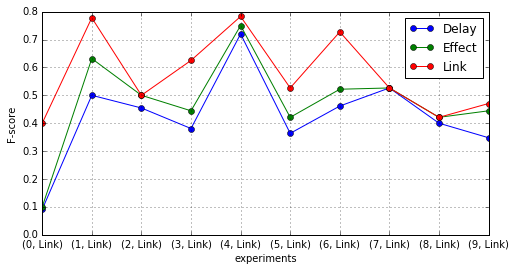

In [248]:
Acu_group.F_score.plot(kind='line',grid=True,x=np.arange(20),figsize =(8,4),marker='o')
plt.xlabel('experiments')
plt.ylabel('F-score')
plt.legend()
plt.savefig('proposed_1' + '.png')
plt.show()


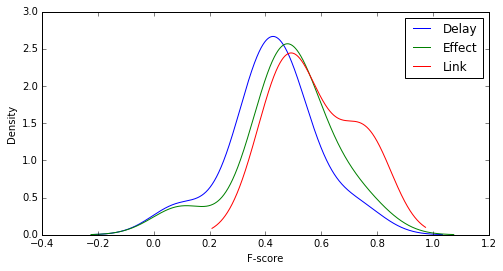

In [249]:
Acu_group.F_score.plot(kind='kde',figsize =(8,4))
plt.legend()
plt.xlabel('F-score')
plt.savefig('proposed_2' + '.png')
plt.show()


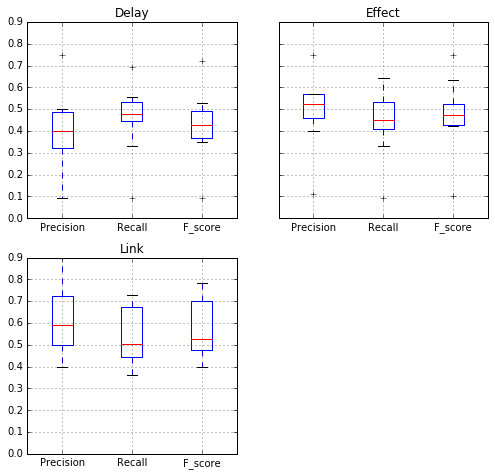

In [250]:
Acu_group.boxplot(column=['Precision','Recall','F_score'],return_type='axes',figsize =(8,8))
plt.savefig('proposed_3' + '.png')

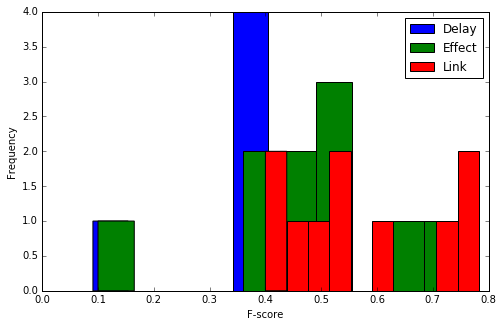

In [251]:
Acu_group.F_score.plot(kind='hist',figsize =(8,5))
plt.legend()
plt.xlabel('F-score')
plt.savefig('proposed_4' + '.png')
plt.show()


# Run of hcc_clinde

In [253]:
columns=['TP','FP','FN','Precision','Recall','F_score']
A=[]
for i in range(n_syn): ## 3 is len(['Link','Delay','Effect'])
    A.extend([i]*3)
        
B=['Link','Delay','Effect']*n_syn
index=[A,B]
Accuracy_clinde=pd.DataFrame(np.random.randint(10, size=(n_syn*3,6)),index=index,columns=columns)   
#####################

for syn in range(n_syn):
    matrix_o=np.load('matrix'+str(syn+1)+'.npy')
    hcc_clinde=pd.read_csv('outgrn_'+str(syn+1)+'.txt',delimiter=" ",header=None)

    columns_clinde=['To','From','Delay','Weight']
    clinde_out=hcc_clinde[[1,3,5,7]]
    clinde_out.columns=columns_clinde


    #######
    n_link=len(clinde_out)
    matrix_p_clinde=np.zeros((max_neurons,obsN, obsN))

    FP_hid=0 
    for link in range(n_link):
        i=int(clinde_out['To'][link])
        j=int(clinde_out['From'][link])
        lag=int(clinde_out['Delay'][link])-1
        if i<obsN and j <obsN:### the generated network does not have a hidden variable, 
            ##if clinde find a link to or from hidden nodes, it is a FP
            if clinde_out['Weight'][link]>=0:
                matrix_p_clinde[lag][i][j]=1
            else:
                matrix_p_clinde[lag][i][j]=-1
        else:
            FP_hid=FP_hid+1


    #####################        

    Link_TP,Link_FP,Link_FN=Link_TP_FP_FN(matrix_o,np.array(matrix_p_clinde),obsN)
    Link_precision, Link_recall, Link_F_score=precision_recall(Link_TP,Link_FP+FP_hid,Link_FN)

    Accuracy_clinde['TP'].iloc[(syn,'Link')]=Link_TP
    Accuracy_clinde['FP'].iloc[(syn,'Link')]=Link_FP+FP_hid
    Accuracy_clinde['FN'].iloc[(syn,'Link')]=Link_FN
    Accuracy_clinde['Precision'].iloc[(syn,'Link')]=Link_precision
    Accuracy_clinde['Recall'].iloc[(syn,'Link')]=Link_recall
    Accuracy_clinde['F_score'].iloc[(syn,'Link')]=Link_F_score  


    ###----------------
    Delay_TP,Delay_FP,Delay_FN=Delay_TP_FP_FN(matrix_o,np.array(matrix_p_clinde),max_neurons,obsN)
    Delay_precision, Delay_recall, Delay_F_score=precision_recall(Delay_TP,Delay_FP+FP_hid,Delay_FN)

    Accuracy_clinde['TP'].loc[(syn,'Delay')]=Delay_TP
    Accuracy_clinde['FP'].loc[(syn,'Delay')]=Delay_FP+FP_hid
    Accuracy_clinde['FN'].loc[(syn,'Delay')]=Delay_FN
    Accuracy_clinde['Precision'].loc[(syn,'Delay')]=Delay_precision
    Accuracy_clinde['Recall'].loc[(syn,'Delay')]=Delay_recall
    Accuracy_clinde['F_score'].loc[(syn,'Delay')]=Delay_F_score

    ###----------------
    Effect_TP,Effect_FP,Effect_FN=Effect_TP_FP_FN(matrix_o,np.array(matrix_p_clinde),max_neurons,obsN)
    Effect_precision, Effect_recall, Effect_F_score=precision_recall(Effect_TP,Effect_FP+FP_hid,Effect_FN)

    Accuracy_clinde['TP'].loc[(syn,'Effect')]=Effect_TP
    Accuracy_clinde['FP'].loc[(syn,'Effect')]=Effect_FP+FP_hid
    Accuracy_clinde['FN'].loc[(syn,'Effect')]=Effect_FN
    Accuracy_clinde['Precision'].loc[syn,'Effect']=Effect_precision
    Accuracy_clinde['Recall'].loc[(syn,'Effect')]=Effect_recall
    Accuracy_clinde['F_score'].loc[(syn,'Effect')]=Effect_F_score 
    
Accuracy_clinde.to_csv('Accuracy_clinde'+str(obsN)+'genes_si_'+str(sigma)+'.csv')
Accuracy_clinde    

C:\Users\mmoradi\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


precision and recall are zero


TP  FP  FN  Precision    Recall   F_score
0 Link     3   1   8   0.750000  0.272727  0.400000
  Delay    3   1   8   0.750000  0.272727  0.400000
  Effect   3   1   8   0.750000  0.272727  0.400000
1 Link     2   2   8   0.500000  0.200000  0.285714
  Delay    2   2   8   0.500000  0.200000  0.285714
  Effect   2   2   8   0.500000  0.200000  0.285714
2 Link     3   3   8   0.500000  0.272727  0.352941
  Delay    3   3   8   0.500000  0.272727  0.352941
  Effect   3   3   8   0.500000  0.272727  0.352941
3 Link     2   1   6   0.666667  0.250000  0.363636
  Delay    2   1   6   0.666667  0.250000  0.363636
  Effect   2   1   6   0.666667  0.250000  0.363636
4 Link     6   0   7   1.000000  0.461538  0.631579
  Delay    6   0   7   1.000000  0.461538  0.631579
  Effect   6   0   7   1.000000  0.461538  0.631579
5 Link     4   2   8   0.666667  0.333333  0.444444
  Delay    0   6  12   0.000000  0.000000  0.000000
  Effect   1   5  11   0.166667  0.083333  0.111111
6 Link     2   0   9   1.000000  0.181818  0.307692
  Delay    2   0   9   1.000000  0.181818  0.307692
  Effect   2   0   9   1.000000  0.181818  0.307692
7 Link     2   4   7   0.333333  0.222222  0.266667
  Delay    2   4   7   0.333333  0.222222  0.266667
  Effect   2   4   7   0.333333  0.222222  0.266667
8 Link     3   3   6   0.500000  0.333333  0.400000
  Delay    3   3   6   0.500000  0.333333  0.400000
  Effect   3   3   6   0.500000  0.333333  0.400000
9 Link     4   2   5   0.666667  0.444444  0.533333
  Delay    3   3   6   0.500000  0.333333  0.400000
  Effect   3   3   6   0.500000  0.333333  0.400000

In [254]:
Acu_group_clinde=Accuracy_clinde.groupby(level=1)
Accuracy_avg_clinde=Acu_group_clinde.mean()
Accuracy_avg_clinde

,TP,FP,FN,Precision,Recall,F_score
Delay,2.6,2.3,7.7,0.575000,0.252770,0.340823
Effect,2.7,2.2,7.6,0.591667,0.261103,0.351934
Link,3.1,1.8,7.2,0.658333,0.297214,0.398601


In [255]:
Accuracy_std_clinde=Acu_group_clinde.std()
Accuracy_std_clinde

,TP,FP,FN,Precision,Recall,F_score
Delay,1.505545,1.888562,1.828782,0.300334,0.120192,0.156881
Effect,1.337494,1.686548,1.577621,0.267735,0.102272,0.132026
Link,1.286684,1.316561,1.229273,0.216773,0.096095,0.113656


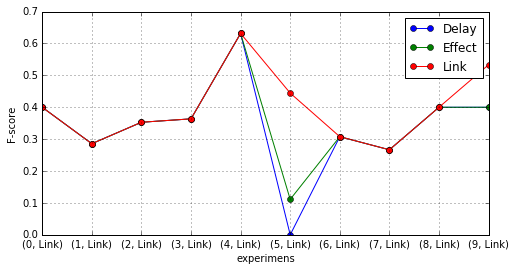

In [256]:
#Acu_group.F_score.plot(kind='line',grid=True,x=np.arange(20),figsize =(8,4))
#plt.hold('on')
Acu_group_clinde.F_score.plot(kind='line',grid=True,x=np.arange(20),figsize =(8,4),marker='o')
plt.xlabel('experimens')
plt.ylabel('F-score')
plt.legend()
plt.savefig('clinde_1' + '.png')
plt.show()

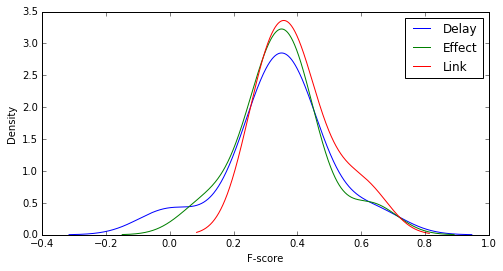

In [257]:
Acu_group_clinde.F_score.plot(kind='kde',figsize =(8,4))
plt.legend()
plt.xlabel('F-score')
plt.savefig('clinde_2' + '.png')
plt.show()

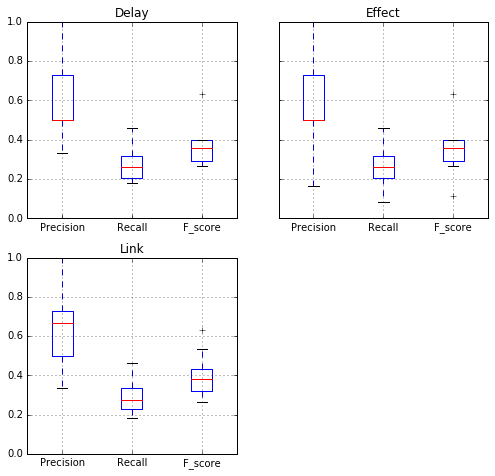

In [258]:
Acu_group_clinde.boxplot(column=['Precision','Recall','F_score'],return_type='axes',figsize =(8,8))
plt.savefig('clinde_3' + '.png')

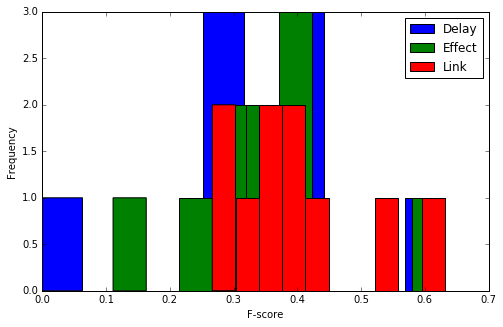

In [259]:
Acu_group_clinde.F_score.plot(kind='hist',figsize =(8,5))
plt.legend()
plt.xlabel('F-score')
plt.savefig('clinde_4' + '.png')
plt.show()

# Multiple runs  of TD-ARACNE

In [260]:
matrix_p_TDA_all=pd.read_csv('TDAnet.csv',header=None)
columns=['TP','FP','FN','Precision','Recall','F_score']
Accuracy_TDA=pd.DataFrame(index=np.arange(n_syn),columns=columns)
    
for syn in range(n_syn):
    matrix_o=np.load('matrix'+str(syn+1)+'.npy')
    
    matrix_p_TDA=matrix_p_TDA_all[(obsN*syn)+np.arange(obsN)]
    matrix_p_TDA=pd.DataFrame.transpose(matrix_p_TDA)
    
    Link_TP_TDA,Link_FP_TDA,Link_FN_TDA=Link_TP_FP_FN(matrix_o,np.array(matrix_p_TDA),obsN)
    Link_precision_TDA, Link_recall_TDA, Link_F_score_TDA=precision_recall(Link_TP_TDA,Link_FP_TDA,Link_FN_TDA)
    
    Accuracy_TDA['TP'].iloc[syn]=Link_TP_TDA
    Accuracy_TDA['FP'].iloc[syn]=Link_FP_TDA
    Accuracy_TDA['FN'].iloc[syn]=Link_FN_TDA
    Accuracy_TDA['Precision'].iloc[syn]=Link_precision_TDA
    Accuracy_TDA['Recall'].iloc[syn]=Link_recall_TDA
    Accuracy_TDA['F_score'].iloc[syn]=Link_F_score_TDA      

In [261]:
Accuracy_TDA.mean()

TP           6.600000
FP           6.900000
FN           3.700000
Precision    0.501667
Recall       0.646119
F_score      0.546151
dtype: float64

In [262]:
Accuracy_TDA.std()

TP           2.011080
FP           2.998148
FN           2.162817
Precision    0.129684
Recall       0.198396
F_score      0.101631
dtype: float64

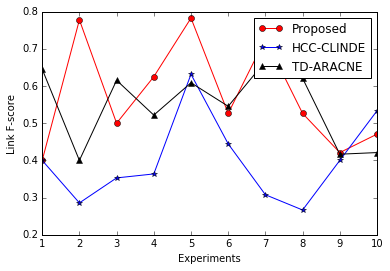

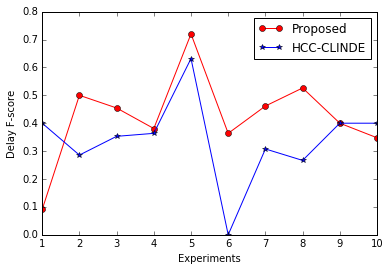

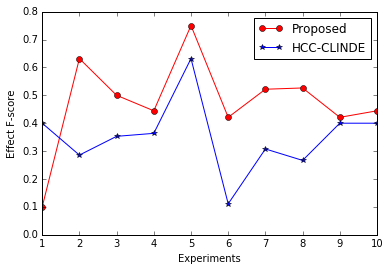

In [263]:
y=np.empty(n_syn)
y_clinde=np.empty(n_syn)
y_delay=np.empty(n_syn)
y_clinde_delay=np.empty(n_syn)
y_effect=np.empty(n_syn)
y_clinde_effect=np.empty(n_syn)
for i in range (n_syn):
    y[i]=Accuracy['F_score'].loc[(i,'Link')]
    y_clinde[i]=Accuracy_clinde['F_score'].loc[(i,'Link')]

    y_delay[i]=Accuracy['F_score'].loc[(i,'Delay')]
    y_clinde_delay[i]=Accuracy_clinde['F_score'].loc[(i,'Delay')]
    
    y_effect[i]=Accuracy['F_score'].loc[(i,'Effect')]
    y_clinde_effect[i]=Accuracy_clinde['F_score'].loc[(i,'Effect')]    
    
plt.figure(1)    
plt.plot(range(1,n_syn+1),y,color='r',marker='o',label='Proposed')
plt.hold('on')
plt.plot(range(1,n_syn+1),y_clinde,color='b',marker='*',label='HCC-CLINDE')
plt.hold('on')
plt.plot(range(1,n_syn+1),Accuracy_TDA['F_score'],color='k',marker='^',label='TD-ARACNE')
plt.xlabel('Experiments')
plt.ylabel('Link F-score')
plt.legend()
plt.savefig('compare_1' + '.png')

plt.figure(2) 
plt.plot(range(1,n_syn+1),y_delay,color='r',marker='o',label='Proposed')
plt.hold('on')
plt.plot(range(1,n_syn+1),y_clinde_delay,color='b',marker='*',label='HCC-CLINDE')
plt.xlabel('Experiments')
plt.ylabel('Delay F-score')
plt.legend()
plt.savefig('compare_2' + '.png')

plt.figure(3) 
plt.plot(range(1,n_syn+1),y_effect,color='r',marker='o',label='Proposed')
plt.hold('on')
plt.plot(range(1,n_syn+1),y_clinde_effect,color='b',marker='*',label='HCC-CLINDE')
plt.xlabel('Experiments')
plt.ylabel('Effect F-score')
plt.legend()
plt.savefig('compare_3' + '.png')




C:\Users\mmoradi\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


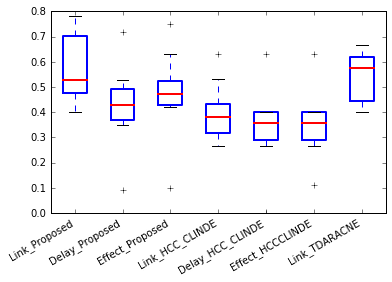

In [264]:
res=pd.DataFrame([y,y_delay,y_effect,y_clinde,y_clinde_delay,y_clinde_effect,Accuracy_TDA['F_score']])
res=pd.DataFrame.transpose(res)
res.columns=['Link_Proposed','Delay_Proposed','Effect_Proposed','Link_HCC_CLINDE',
                      'Delay_HCC_CLINDE','Effect_HCCCLINDE','Link_TDARACNE']
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=2, color='r')
#pd.DataFrame.boxplot(res,boxprops=boxprops,medianprops=medianprops)

fig, ax = plt.subplots()
res.plot(ax=ax, kind='box', legend=False,boxprops=boxprops,medianprops=medianprops)
fig.autofmt_xdate()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('results-tilted.png', bbox_inches='tight')

plt.savefig('compare_4' + '.png')

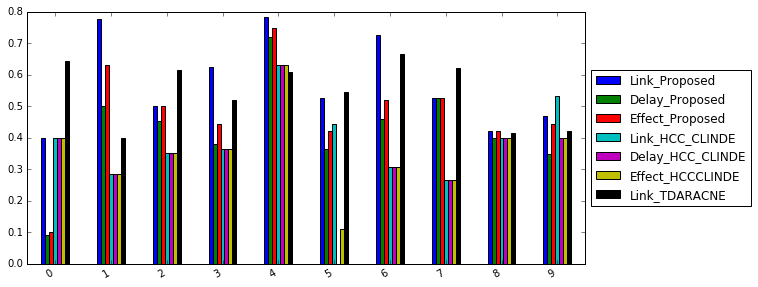

In [265]:
res=pd.DataFrame([y,y_delay,y_effect,y_clinde,y_clinde_delay,y_clinde_effect,Accuracy_TDA['F_score']])
res=pd.DataFrame.transpose(res)
res.columns=['Link_Proposed','Delay_Proposed','Effect_Proposed','Link_HCC_CLINDE',
                      'Delay_HCC_CLINDE','Effect_HCCCLINDE','Link_TDARACNE']
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=2, color='r')
#pd.DataFrame.boxplot(res,boxprops=boxprops,medianprops=medianprops)

fig, ax = plt.subplots()
res.plot(ax=ax, kind='bar', legend=False,figsize=(10,5))
fig.autofmt_xdate()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('results-tilted.png', bbox_inches='tight')

plt.savefig('compare_5' + '.png')

In [ ]:
"""
matrix_o,weight_o=orig_matrix()
np.save('matrix',matrix_o)

T=50         ## length of time series
delay=max_neurons-1
Data_orig=np.random.uniform(-1,1,[T+delay,obsN])
Data_orig[delay+1:,:]=np.zeros([T-1,obsN])

si_max=2     ###   maximum variance of noise
for sigma in [1]:
    Data=Data_orig.copy()
    for t in range(delay,T+delay-1):
        for lag in range(0,delay+1):
            Data[t+1,:]=Data[t+1,:]+np.dot(weight_o[lag],Data[t-lag,:]) ##  Linear
            #Data[t+1,:]=Data[t+1,:]+np.tanh(np.dot(weight_o[lag],Data[t-lag,:])) ## Nonlinear
        Data[t+1,:]=Data[t+1,:]+np.random.normal(0, sigma) 
    Data2=Data[delay:,:]     
    np.savetxt('Data_si'+str(sigma)+'.csv',Data2, delimiter=",")
plt.plot(Data2)
plt.show()  
""" 

In [ ]:
"""
if __name__ == '__main__':
    #runs=10
    columns=['TP','FP','FN','Precision','Recall','F_score']
    A=[]
    for i in range(runs): ## 3 is len(['Link','Delay','Effect'])
        A.extend([i]*3)
        
    B=['Link','Delay','Effect']*runs
    index=[A,B]
    Accuracy=pd.DataFrame(np.random.randint(10, size=(runs*3,6)),index=index,columns=columns)    
        
        
    """    
    B=list(range(0, 3))*runs
    index=pd.MultiIndex(levels=[np.arange(runs),['Link','Delay','Effect']], labels=[A,B])
    Accuracy=pd.DataFrame(index=index,columns=columns)
    """
    ###-----------------------------
    
    matrix_o=np.load('matrix.npy')
    matrix_P=[]
    Fits=[]
    for run in tqdm(range(runs)): # multiple runs of the algorithm
        result= parallel_calc(num_cores)  
        
        fit,nets=[],[]
        for net, i in result:
            fit.append(i)
            nets.append(net)
        Fits.append(sum(fit))
        matrix_p=pre_matrix(nets,max_neurons,obsN) 
        
        matrix_P.append(matrix_p)
        
        
        
        ###----------------
        Link_TP,Link_FP,Link_FN=Link_TP_FP_FN(matrix_o,matrix_p,obsN)
        Link_precision, Link_recall, Link_F_score=precision_recall(Link_TP,Link_FP,Link_FN)
        
        Accuracy['TP'].loc[(run,'Link')]=Link_TP
        Accuracy['FP'].loc[(run,'Link')]=Link_FP
        Accuracy['FN'].loc[(run,'Link')]=Link_FN
        Accuracy['Precision'].loc[(run,'Link')]=Link_precision
        Accuracy['Recall'].loc[(run,'Link')]=Link_recall
        Accuracy['F_score'].loc[(run,'Link')]=Link_F_score
        
        ###----------------
        Delay_TP,Delay_FP,Delay_FN=Delay_TP_FP_FN(matrix_o,matrix_p,max_neurons,obsN)
        Delay_precision, Delay_recall, Delay_F_score=precision_recall(Delay_TP,Delay_FP,Delay_FN)
        
        Accuracy['TP'].loc[(run,'Delay')]=Delay_TP
        Accuracy['FP'].loc[(run,'Delay')]=Delay_FP
        Accuracy['FN'].loc[(run,'Delay')]=Delay_FN
        Accuracy['Precision'].loc[(run,'Delay')]=Delay_precision
        Accuracy['Recall'].loc[(run,'Delay')]=Delay_recall
        Accuracy['F_score'].loc[(run,'Delay')]=Delay_F_score

        ###----------------
        Effect_TP,Effect_FP,Effect_FN=Effect_TP_FP_FN(matrix_o,matrix_p,max_neurons,obsN)
        Effect_precision, Effect_recall, Effect_F_score=precision_recall(Effect_TP,Effect_FP,Effect_FN)
        
        Accuracy['TP'].loc[(run,'Effect')]=Effect_TP
        Accuracy['FP'].loc[(run,'Effect')]=Effect_FP
        Accuracy['FN'].loc[(run,'Effect')]=Effect_FN
        Accuracy['Precision'].loc[run,'Effect']=Effect_precision
        Accuracy['Recall'].loc[(run,'Effect')]=Effect_recall
        Accuracy['F_score'].loc[(run,'Effect')]=Effect_F_score
    
    
    np.save('matrix_predict',matrix_P)
plt.plot(Fits)    
"""     